15.12.2021

# Validate U-Net predictions

Load a bunch of UNet predictions in folder `trainings_validation` and compute some metrics, plots, etc.

Predictions are saved as:
`{training_name}_{epoch}_{video_id}_{class}.tif`

**Idea**: Use predictions to produce plots and tables to visualize the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
import os
import imageio
from collections import defaultdict
import pprint

from scipy.ndimage.morphology import binary_dilation, binary_erosion
from sklearn.metrics import jaccard_score, f1_score

import pandas as pd
import matplotlib.pyplot as plt

import unet
from metrics_tools import (correspondences_precision_recall, 
                           Metrics, 
                           reduce_metrics, 
                           empty_marginal_frames,
                           process_spark_prediction,
                           process_puff_prediction,
                           process_wave_prediction,
                           jaccard_score_exclusion_zone,
                           write_videos_on_disk,
                           get_sparks_locations_from_mask,
                           compute_prec_rec,
                           reduce_metrics_thresholds
                          )

In [3]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

# Load data

### Select predictions to load

In [4]:
training_names = [#"256_long_chunks_ubelix",
                  "focal_loss_gamma_5_ubelix"
                  ]

epoch = 100000

### Configure input/output folder (TODO: aggiungere training name nella path nelle altre sections)

In [5]:
metrics_folder = "trainings_validation"
# TODO: cambiare nelle altre fcts!!
os.makedirs(metrics_folder, exist_ok=True)

### Load annotations
open and process annotations (original version, sparks not processed)


In [6]:
from dataset_tools import load_annotations

ys_all_trainings = load_annotations(metrics_folder, mask_names="mask")

#ys_filenames = sorted(glob.glob(os.path.join(metrics_folder, "[0-9]*_video_mask.tif")))

#for f in ys_filenames:
#    video_id = os.path.split(f)[1][:2]
#    ys_all_trainings[video_id] = np.asarray(imageio.volread(f)).astype('int')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [7]:
ys_all_trainings.keys()

dict_keys(['05', '10', '15', '20', '25', '32', '34', '40', '45'])

### Load predictions

In [8]:
ys = {} # contains annotations for each training
sparks = {} # contains sparks for each training
puffs = {} # contains puffs for each training
waves = {} # contains waves for each training

for training_name in training_names:
    data_folder = os.path.join(metrics_folder, training_name)
    print(f"Processing training name {training_name}...")
    print()
    # Import .tif files as numpy array
    base_name = os.path.join(data_folder,training_name+"_"+str(epoch)+"_")
    
    if training_name == "temporal_reduction": # need to use annotations from another training
        if training_names[-1] != "temporal_reduction":
            base_name_ys = os.path.join(data_folder,training_names[-1]+"_"+str(epoch)+"_")
            ys_filenames = sorted(glob.glob(base_name_ys+"[0-9][0-9]_video_ys.tif"))
        else:
            print("SELECT TRAINING NAME DIFFERENT FROM temporal_reduction")
            break
    else:    
        ys_filenames = sorted(glob.glob(base_name+"*_ys.tif"))
        
    sparks_filenames = sorted(glob.glob(base_name+"[0-9][0-9]_video_sparks.tif"))
    puffs_filenames = sorted(glob.glob(base_name+"[0-9][0-9]_video_puffs.tif"))
    waves_filenames = sorted(glob.glob(base_name+"[0-9][0-9]_video_waves.tif"))
        
    training_ys = {}
    training_sparks = {}
    training_puffs = {}
    training_waves = {}
    
    for idx,y,s,p,w in zip(ys_all_trainings.keys(),ys_filenames,sparks_filenames,puffs_filenames,waves_filenames):
        #print(f"\tProcessing the following files for movie {idx}:")
        #print(f"\tAnnotations filename: {y}")
        #print(f"\tSparks filename: {s}")
        #print(f"\tPuffs filename: {p}")
        #print(f"\tWaves filename: {w}\t")
        #print()
        ys_loaded = np.asarray(imageio.volread(y)).astype('int')
        training_ys[idx] = ys_loaded
        
        if training_name == "temporal_reduction": # repeat each frame 4 times
            s_preds = np.asarray(imageio.volread(s))
            p_preds = np.asarray(imageio.volread(p))
            w_preds = np.asarray(imageio.volread(w))
                        
            # repeat predicted frames x4
            s_preds = np.repeat(s_preds,4,0)
            p_preds = np.repeat(p_preds,4,0)
            w_preds = np.repeat(w_preds,4,0)
            
            # if original length %4 != 0, crop preds
            if ys_loaded.shape != s_preds.shape:
                duration = ys_loaded.shape[0]
                s_preds = s_preds[:duration]
                p_preds = p_preds[:duration]
                w_preds = w_preds[:duration]
            
            assert ys_loaded.shape == s_preds.shape
            assert ys_loaded.shape == p_preds.shape
            assert ys_loaded.shape == w_preds.shape
            
            training_sparks[idx] = s_preds
            training_puffs[idx] = p_preds
            training_waves[idx] = w_preds
        else:
            training_sparks[idx] = np.asarray(imageio.volread(s))
            training_puffs[idx] = np.asarray(imageio.volread(p))
            training_waves[idx] = np.asarray(imageio.volread(w))

    ys[training_name] = training_ys
    sparks[training_name] = training_sparks
    puffs[training_name] = training_puffs
    waves[training_name] = training_waves       

Processing training name focal_loss_gamma_5_ubelix...



# Jaccard index (IoU score) for puffs and waves
12.05.2021
Seguendo il consiglio di Pablo:
erosion & dilation delle annotations -> creazione di una exclusion region che viene ignorata dal supporto del Jaccard index

## Compute metrics for sample video

In [12]:
# results for a sample movie in sample dataset
name = "256_long_chunks_64_step_physio"
idx = 0

In [27]:
# parameters
ignore_frames = 6

t_detection = 0.5
min_radius_puffs = 4
min_radius_waves = 10

### Get binary preds and remove ignored frames

In [14]:
# get predictions
sparks_sample = sparks[name][idx]
puffs_sample = puffs[name][idx]
waves_sample = waves[name][idx]

KeyError: '256_long_chunks_64_step_physio'

In [ ]:
puffs_binary = process_puff_prediction(puffs_sample, 
                                       t_detection, 
                                       min_radius_puffs, 
                                       ignore_frames)

waves_binary = process_wave_prediction(waves_sample, 
                                       t_detection, 
                                       min_radius_waves, 
                                       ignore_frames)

### Get binary ys and remove ignored frames

In [ ]:
# get binary ys
ys_sample = ys_all_trainings[idx]

ys_puffs_sample = np.where(ys_sample==3,1,0)
ys_waves_sample = np.where(ys_sample==2,1,0)
ignore_mask = np.where(ys_sample==4,1,0)

In [ ]:
ys_puffs_sample = empty_marginal_frames(ys_puffs_sample, ignore_frames)
ys_waves_sample = empty_marginal_frames(ys_waves_sample, ignore_frames)
ignore_mask = empty_marginal_frames(ignore_mask, ignore_frames)

### Plot a sample frame

In [ ]:
sparks_sample.shape, puffs_sample.shape, waves_sample.shape, ys_sample.shape

In [ ]:
sample_frame = 199 # 346

In [ ]:
# Plot annotations and preds of sample frame

#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,8))
plt.suptitle(f"Annotations and preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(4,2,1)
ax.set_title("Puffs annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(4,2,2)
ax.set_title("Waves annotations")
plt.imshow(ys_waves_sample[sample_frame])

ax = plt.subplot(4,2,3)
ax.set_title("Puffs binary preds")
plt.imshow(puffs_binary[sample_frame])

ax = plt.subplot(4,2,4)
ax.set_title("Waves binary preds")
plt.imshow(waves_binary[sample_frame])

ax = plt.subplot(4,2,5)
ax.set_title("Puffs original preds")
plt.imshow(puffs_sample[sample_frame])

ax = plt.subplot(4,2,6)
ax.set_title("Waves original preds")
plt.imshow(waves_sample[sample_frame])

ax = plt.subplot(4,2,7)
ax.set_title("Ignore mask (annotations)")
plt.imshow(ignore_mask[sample_frame])


plt.show()

### Save sample binary preds on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_puffs.tif"), np.uint8(puffs_binary))
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_waves.tif"), np.uint8(waves_binary))

### Save sample annotations on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "annotations_puffs.tif"), np.uint8(ys_puffs_sample))
imageio.volwrite(os.path.join(metrics_folder, "annotations_waves.tif"), np.uint8(ys_waves_sample))

### Save ignore mask on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "ignore_mask.tif"), np.uint8(ignore_mask))

### Compute Jaccard score (without exclusion zone)

In [21]:
iou_puffs = jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())
iou_waves = jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())

print(f"Jaccard score puffs: {iou_puffs}")
print(f"Jaccard score waves: {iou_waves}")

Jaccard score puffs: 0.16206809118779245
Jaccard score waves: 0.0


C:\Users\dotti\.conda\envs\sparks\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Compute exclusion zone

exclusion_radius = 2

In [23]:
# Just for puffs
puffs_eroded = binary_erosion(ys_puffs_sample, iterations=exclusion_radius)
puffs_dilated = binary_dilation(ys_puffs_sample, iterations=exclusion_radius)

exclusion_mask = 1 - np.logical_xor(puffs_eroded, puffs_dilated)
# 1 where Jaccard index has to be computed, 0 otherwise

In [24]:
# Compute dilation for ignore mask
ignore_mask_dilated = binary_dilation(ignore_mask, iterations=exclusion_radius)

# Ignore regions in ignore mask too
exclusion_mask_ignore_roi = np.logical_and(1 - ignore_mask_dilated, exclusion_mask)

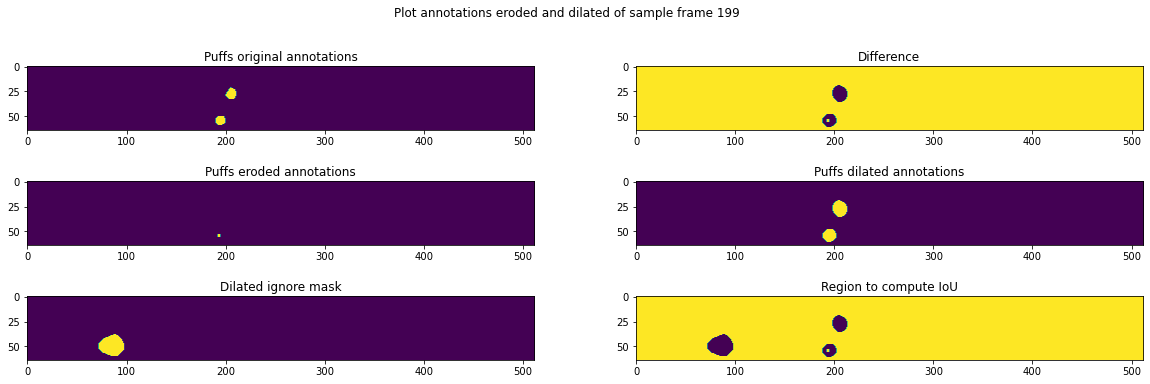

In [25]:
# Plot annotations eroded and dilated
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,6))
plt.suptitle(f"Plot annotations eroded and dilated of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(3,2,1)
ax.set_title("Puffs original annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(3,2,2)
ax.set_title("Difference")
plt.imshow(exclusion_mask[sample_frame])

ax = plt.subplot(3,2,3)
ax.set_title("Puffs eroded annotations")
plt.imshow(puffs_eroded[sample_frame])

ax = plt.subplot(3,2,4)
ax.set_title("Puffs dilated annotations")
plt.imshow(puffs_dilated[sample_frame])

ax = plt.subplot(3,2,5)
ax.set_title("Dilated ignore mask")
plt.imshow(ignore_mask_dilated[sample_frame])

ax = plt.subplot(3,2,6)
ax.set_title("Region to compute IoU")
plt.imshow(exclusion_mask_ignore_roi[sample_frame])


plt.show()

In [26]:
# Compute intersection and union of annotations with preds

intersection = np.logical_and(ys_puffs_sample, puffs_binary)
union = np.logical_or(ys_puffs_sample, puffs_binary)

# Compute intersection and union only in exclusion mask

intersection_mask = np.logical_and(intersection, exclusion_mask_ignore_roi)
union_mask = np.logical_and(union, exclusion_mask_ignore_roi)

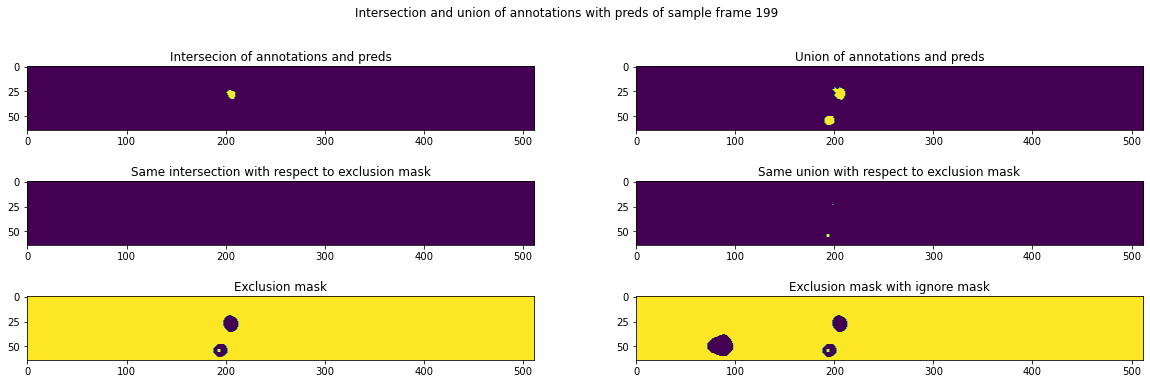

In [27]:
# Plot intersection and union
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,6))
plt.suptitle(f"Intersection and union of annotations with preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(3,2,1)
ax.set_title("Intersecion of annotations and preds")
plt.imshow(intersection[sample_frame])

ax = plt.subplot(3,2,2)
ax.set_title("Union of annotations and preds")
plt.imshow(union[sample_frame])

ax = plt.subplot(3,2,3)
ax.set_title("Same intersection with respect to exclusion mask")
plt.imshow(intersection_mask[sample_frame])

ax = plt.subplot(3,2,4)
ax.set_title("Same union with respect to exclusion mask")
plt.imshow(union_mask[sample_frame])

ax = plt.subplot(3,2,5)
ax.set_title("Exclusion mask")
plt.imshow(exclusion_mask[sample_frame])

ax = plt.subplot(3,2,6)
ax.set_title("Exclusion mask with ignore mask")
plt.imshow(exclusion_mask_ignore_roi[sample_frame])


plt.show()

In [28]:
# Compute Jaccard index

print(f"Pixels in intersection: {np.count_nonzero(intersection_mask)}")
print(f"Pixels in union: {np.count_nonzero(union_mask)}")

new_iou_puffs = np.count_nonzero(intersection_mask)/np.count_nonzero(union_mask)

print(f"IoU wrt to wave class: {new_iou_puffs}")

Pixels in intersection: 16943
Pixels in union: 136282
IoU wrt to wave class: 0.12432309475939596


In [29]:
new_iou_puffs = jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, exclusion_radius, ignore_mask)
new_iou_waves = jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, exclusion_radius, ignore_mask)

In [30]:
print(new_iou_puffs)
print(new_iou_waves)

0.12432309475939596
1.0


### Jaccard index for sparks

In [73]:
# get sparks annotations
ys_sparks_sample = np.where(ys_sample==1,1,0)

# get sparks predictions
t_detection_sparks = 0.9
min_radius_sparks = 3
sparks_binary = (process_spark_prediction(sparks_sample, 
                                          t_detection=t_detection_sparks,
                                          min_radius=min_radius_sparks,
                                          ignore_frames=ignore_frames,
                                          return_clean_pred=True)) != 0 

### Comparison with original implementation (when radius = 0)

In [76]:
print("Jaccard index with new method:")
print(f"Puffs: {jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, 0)}") # ! not considering ignore mask
print(f"Waves: {jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, 0)}") # ! not considering ignore mask
print(f"Sparks: {jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, 0, sparks=True)}") # ! not considering ignore mask
print()
print("Jaccard index with sklearn metrics method")
print(f"Puffs: {jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())}")
print(f"Waves: {jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())}")
print(f"Sparks: {jaccard_score(ys_sparks_sample.ravel(), sparks_binary.ravel())}")

Jaccard index with new method:
Puffs: 0.20890103174317864
Waves: 1.0
Sparks: 0.04723618090452261

Jaccard index with sklearn metrics method
Puffs: 0.20890103174317864
Waves: 0.0
Sparks: 0.04723618090452261


### Plot IoU with respect to different exclusion radius

In [77]:
exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# puffs
ious_puffs = []
for radius in exclusion_radius_list:
    ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius)) # ! not considering ignore mask
    
# waves
ious_waves = []
for radius in exclusion_radius_list:
    ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius)) # ! not considering ignore mask
    
# sparks
ious_sparks = []
for radius in exclusion_radius_list:
    ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, sparks=True)) # ! not considering ignore mask

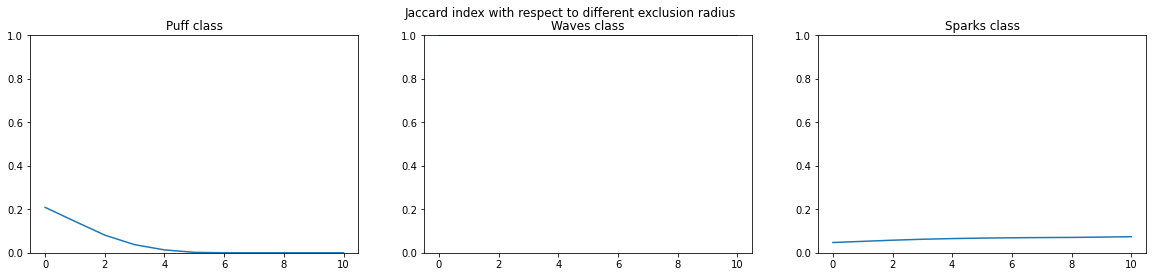

In [78]:
# Plot Jaccard index wrt different exclusion radius
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Jaccard index with respect to different exclusion radius", fontsize=12)


ax = plt.subplot(1,3,1)
ax.set_title("Puff class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_puffs)

ax = plt.subplot(1,3,2)
ax.set_title("Waves class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_waves)

ax = plt.subplot(1,3,3)
ax.set_title("Sparks class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_sparks)


plt.show()

In [79]:
print(f"IoUs puffs: {ious_puffs}")
print(f"IoUs puffs: {ious_waves}")
print(f"IoUs puffs: {ious_sparks}")

IoUs puffs: [0.20890103174317864, 0.14459408432976714, 0.08126801152737752, 0.037353441136730156, 0.013306755737528283, 0.0021321961620469083, 7.474400179385604e-05, 0.0, 0.0, 0.0, 0.0]
IoUs puffs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IoUs puffs: [0.04723618090452261, 0.05264336917562724, 0.05791030064070971, 0.06230116648992577, 0.06536856745479833, 0.06762589928057554, 0.06909732431637754, 0.07004470938897168, 0.07078313253012049, 0.07219662058371736, 0.07413249211356467]


## Evaluate all trainings on all videos (plain version using exclusion radius)

Remarks: 
- IoU not computed for sparks (it doesn't make sense)

In [31]:
# params best for focal_loss_gamma_5_ubelix

# parameters
ignore_frames = 6

# sparks params
#t_detection_sparks = 0.7
#min_radius_sparks = 2

# puffs and waves params
t_detection = [0.5,0.55,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
min_radius = [0,1,2,3,4,5,6,7,8,9,10]

exclusion_radius = [0,1,2,3,4,5,6,7,8,9,10]

In [32]:
# each dictionary contains, for every training name, a list of IoU scores for all videos for all exclusion radius
ious_puffs_all_models = {}
ious_waves_all_models = {}
ious_puffs_all_models_average = {}
ious_waves_all_models_average = {}

for training_name in training_names:
    print(training_name)
    # get predictions
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
        
    ious_puffs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    ious_waves = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    ious_puffs_average = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    ious_waves_average = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    for video_id in ys_all_trainings.keys():
        ys_sample = ys_all_trainings[video_id]
        puffs_sample = puffs_training[video_id]
        waves_sample = waves_training[video_id]
        
        # get ignore mask (events labelled with 4)
        ignore_mask = empty_marginal_frames(np.where(ys_sample==4,1,0), ignore_frames)
        
        for t in t_detection:
            for min_r in min_radius:
                # get binary predictions and remove ignored frames
                puffs_binary = process_puff_prediction(pred=puffs_sample, 
                                                       t_detection=t, 
                                                       min_radius=min_r, 
                                                       ignore_frames=ignore_frames)
                waves_binary = process_wave_prediction(waves_sample, 
                                                       t_detection=t, 
                                                       min_radius=min_r, 
                                                       ignore_frames=ignore_frames)

                # get binary ys and remove ignored frames
                ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
                ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)

                # compute IoU for some exclusion radius values
                # puffs
                for exclusion_r in exclusion_radius:
                    ious_puffs[t][min_r][exclusion_r][video_id] = jaccard_score_exclusion_zone(ys=ys_puffs_sample,
                                                                                               preds=puffs_binary,
                                                                                               exclusion_radius=exclusion_r,
                                                                                               ignore_mask=ignore_mask)

                # waves
                ious_waves = {}
                for exclusion_r in exclusion_radius:
                    ious_waves[t][min_r][exclusion_r][video_id] = jaccard_score_exclusion_zone(ys=ys_waves_sample,
                                                                                               preds=waves_binary,
                                                                                               exclusion_radius=exclusion_r,
                                                                                               ignore_mask=ignore_mask)
        # compute average over all movies
        ious_puffs_average[t][min_r][exclusion_r] = sum(ious_puffs[t][min_r][exclusion_r].values()) / len(ious_puffs[t][min_r][exclusion_r])
        ious_waves_average[t][min_r][exclusion_r] = sum(ious_waves[t][min_r][exclusion_r].values()) / len(ious_waves[t][min_r][exclusion_r])
    
    ious_puffs_all_models[training_name] = ious_puffs
    ious_waves_all_models[training_name] = ious_waves
    ious_puffs_all_models_average[training_name] = ious_puffs_average
    ious_waves_all_models_average[training_name] = ious_waves_average

focal_loss_gamma_5_ubelix


KeyError: 0.5

In [10]:
pprint.pprint(ious_puffs_all_trainings)

{'focal_loss_gamma_5_ubelix': {'05': {0: 0.14720359588217147,
                                      1: 0.1362367721747881,
                                      2: 0.10492437838939066,
                                      3: 0.07402837754472548,
                                      4: 0.04507901506798971,
                                      5: 0.022757923128792986,
                                      6: 0.008515840508233721,
                                      7: 0.0020303841008981463,
                                      8: 0.00018667911194079605,
                                      9: 0.0,
                                      10: 0.0},
                               '10': {0: 0.5663674907955643,
                                      1: 0.6396018813866267,
                                      2: 0.6982539775311736,
                                      3: 0.7583326657752198,
                                      4: 0.8181698381740551,
                                     

### Compute average along videos of IoU for each exclusion radius for each training name

In [11]:
ious_sparks_avg = {} # num training x num exclusion radius
ious_puffs_avg = {}
ious_waves_avg = {}

for training_name in training_names:
    num_videos = len(ious_sparks_all_trainings[training_name])
    
    ious_sparks_all_video = ious_sparks_all_trainings[training_name] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_trainings[training_name] 
    ious_waves_all_video = ious_waves_all_trainings[training_name]
    
    ious_sparks_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_sparks_all_video.values()]),0)/num_videos
    ious_puffs_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_puffs_all_video.values()]),0)/num_videos
    ious_waves_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_waves_all_video.values()]),0)/num_videos

### Plot average IoU for all trainings and all classes wrt to exclusion radius

In [12]:
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Sparks', 'Puffs', 'Waves']
rows = pd.MultiIndex.from_product([classes, training_names], names=['Class', 'Training name'])

data = [*ious_sparks_avg.values(),
        *ious_puffs_avg.values(),
        *ious_waves_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [13]:
display(df)

,Exclusion radius,0,1,2,3,4,5,6,7,8,9,10
Class,Training name,,,,,,,,,,,
Sparks,focal_loss_gamma_5_ubelix,0.111355,0.116198,0.118321,0.119828,0.120919,0.121744,0.122456,0.123084,0.123650,0.124255,0.125022
Puffs,focal_loss_gamma_5_ubelix,0.307379,0.319243,0.324484,0.327107,0.327145,0.325298,0.322010,0.317473,0.312107,0.305883,0.300132
Waves,focal_loss_gamma_5_ubelix,0.788636,0.800115,0.802833,0.805084,0.806882,0.808387,0.809571,0.810544,0.811264,0.811798,0.812080


In [14]:
df.to_csv("average_IoU_all_trainings_excl_radius.csv")

Text(0.5, 0, 'Exclusion radius')

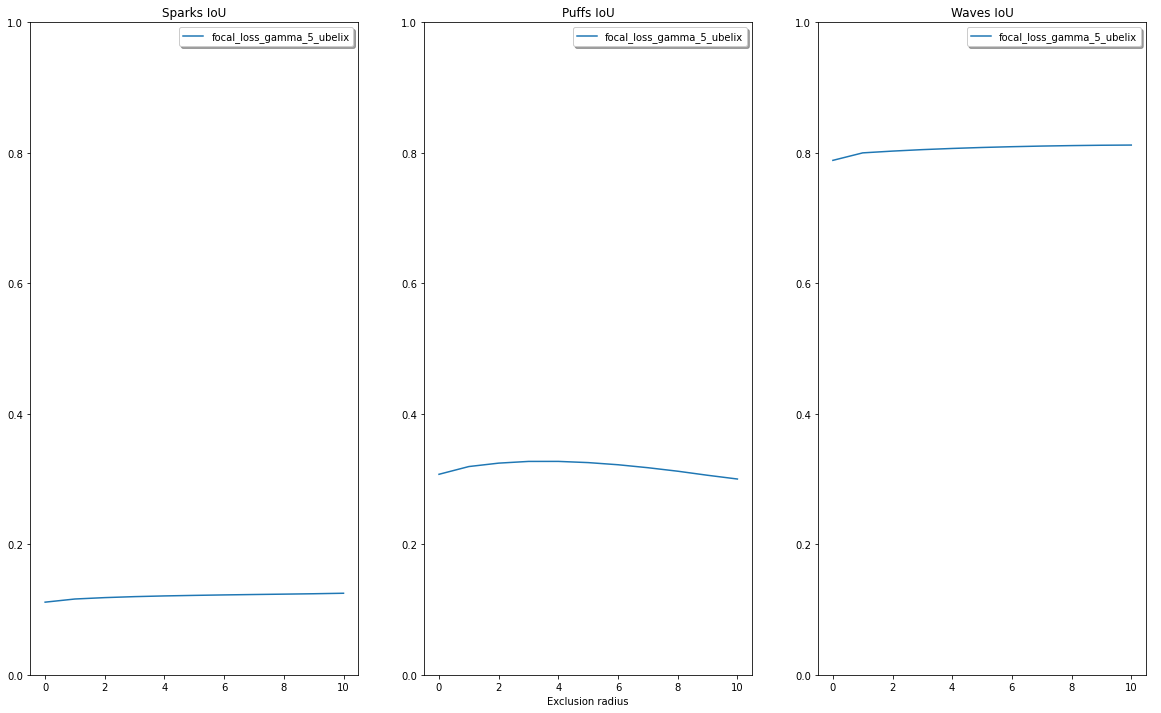

In [15]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs[0].plot(exclusion_radius_list, ious_sparks_avg[training_name], label=training_name)
           
axs[0].set_title('Sparks IoU')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[1].plot(exclusion_radius_list, ious_puffs_avg[training_name], label=training_name)

axs[1].set_title('Puffs IoU')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[2].plot(exclusion_radius_list, ious_waves_avg[training_name], label=training_name)

axs[2].set_title('Waves IoU')
axs[2].set_ylim([0,1])
axs[2].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

In [16]:
fig.savefig("average_IoU_all_trainings_excl_radius.png")

## Plot average IoU for different minimal event radius (just for one training)

In [38]:
# set sample training
training_name = training_names[0]

# parameters
ignore_frames = 6

t_detection = 0.5
t_detection_sparks = 0.9

min_radius = [0,1,2,3,4]#,5,6,7,8,9,10]

exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# each dictionary contains, for every minimal event radius, a list of IoU scores averaged on all videos for all exclusion radius
ious_sparks_all_radius = {} # num min event radius x num ious_sparks_avg_radiususion radius
ious_puffs_all_radius = {}
ious_waves_all_radius = {}

for r in min_radius:
    # get predictions
    sparks_training = sparks[training_name]
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
    
    ious_puffs_all_video = []
    ious_waves_all_video = []
    ious_sparks_all_video = []
    
    for sparks_sample, puffs_sample, waves_sample, ys_sample in zip(sparks_training, puffs_training, waves_training, ys_all_trainings):
        # get binary predictions and remove ignored frames
        puffs_binary = process_puff_prediction(puffs_sample, 
                                               t_detection, 
                                               r, 
                                               ignore_frames)
        waves_binary = process_wave_prediction(waves_sample, 
                                               t_detection, 
                                               r, 
                                               ignore_frames)
        sparks_binary = (process_spark_prediction(sparks_sample, 
                                                  t_detection=t_detection_sparks,
                                                  min_radius=r,
                                                  ignore_frames=ignore_frames,
                                                  return_clean_pred=True)) != 0 
        
        # get binary ys and remove ignored frames
        ys_sparks_sample = empty_marginal_frames(np.where(ys_sample==1,1,0), ignore_frames)
        ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
        ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)
        
        # get ignore regions during training
        ignore_mask =  empty_marginal_frames(np.where(ys_sample==4,1,0), ignore_frames)
        
        
        # compute IoU for some exclusion radius values
        # puffs
        ious_puffs = []
        for radius in exclusion_radius_list:
            ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius, ignore_mask))
            
        ious_puffs_all_video.append(ious_puffs)

        # waves
        ious_waves = []
        for radius in exclusion_radius_list:
            ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius, ignore_mask))
            
        ious_waves_all_video.append(ious_waves)

        # sparks
        ious_sparks = []
        for radius in exclusion_radius_list:
            ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, ignore_mask, sparks=True))
            
        ious_sparks_all_video.append(ious_sparks)
        
    ious_sparks_all_radius[r] = ious_sparks_all_video
    ious_puffs_all_radius[r] = ious_puffs_all_video
    ious_waves_all_radius[r] = ious_waves_all_video

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,1)  and requested shape (0,2)

### Compute average along videos of IoU for each exclusion radius for each minimal event radius

In [27]:
ious_sparks_avg_radius = {} # num min event radius x num exclusion radius
ious_puffs_avg_radius = {}
ious_waves_avg_radius = {}

for r in min_radius:
    num_videos = len(ious_sparks_all_radius[r])
    
    ious_sparks_all_video = ious_sparks_all_radius[r] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_radius[r] 
    ious_waves_all_video = ious_waves_all_radius[r] 
    
    ious_sparks_avg_radius[r] = np.sum(np.asarray(ious_sparks_all_video),0)/num_videos
    ious_puffs_avg_radius[r] = np.sum(np.asarray(ious_puffs_all_video),0)/num_videos
    ious_waves_avg_radius[r] = np.sum(np.asarray(ious_waves_all_video),0)/num_videos

### Plot average IoU for all minimal event radius and all classes wrt to exclusion radius

In [28]:
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Sparks', 'Puffs', 'Waves']
rows = pd.MultiIndex.from_product([classes, min_radius], names=['Class', 'Minimal event radius'])

data = [*ious_sparks_avg_radius.values(),
        *ious_puffs_avg_radius.values(),
        *ious_waves_avg_radius.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [29]:
display(df)

Exclusion radius                   0         1         2         3         4   \
Class  Minimal event radius                                                     
Sparks 0                     0.116289  0.121549  0.124016  0.125769  0.126827   
       1                     0.116353  0.121615  0.124085  0.125840  0.126898   
       2                     0.116751  0.122073  0.124606  0.126406  0.127487   
       3                     0.103926  0.108681  0.110933  0.112574  0.113627   
       4                     0.076986  0.080729  0.082704  0.084224  0.085273   
Puffs  0                     0.195051  0.205668  0.210015  0.212122  0.213422   
       1                     0.195059  0.205676  0.210027  0.212133  0.213432   
       2                     0.195131  0.205738  0.210082  0.212183  0.213470   
       3                     0.195202  0.205803  0.210151  0.212229  0.213474   
       4                     0.195353  0.205897  0.210204  0.212282  0.213591   
Waves  0                     0.787339  0.799457  0.802117  0.804287  0.806003   
       1                     0.787339  0.799457  0.802117  0.804288  0.806003   
       2                     0.787344  0.799462  0.802123  0.804294  0.806010   
       3                     0.787349  0.799467  0.802127  0.804299  0.806015   
       4                     0.787358  0.799477  0.802138  0.804309  0.806025   

Exclusion radius                   5         6         7         8         9   \
Class  Minimal event radius                                                     
Sparks 0                     0.127459  0.127829  0.128049  0.128149  0.128194   
       1                     0.127530  0.127900  0.128119  0.128220  0.128264   
       2                     0.128136  0.128517  0.128742  0.128843  0.128886   
       3                     0.114285  0.114670  0.114889  0.114978  0.115004   
       4                     0.085928  0.086289  0.086464  0.086526  0.086543   
Puffs  0                     0.215477  0.218401  0.221077  0.223142  0.224177   
       1                     0.215484  0.218405  0.221079  0.223143  0.224178   
       2                     0.215500  0.218409  0.221071  0.223128  0.224159   
       3                     0.215464  0.218364  0.221037  0.223125  0.224159   
       4                     0.215688  0.218741  0.221614  0.223923  0.225162   
Waves  0                     0.807289  0.808214  0.808830  0.809212  0.809271   
       1                     0.807289  0.808214  0.808831  0.809213  0.809273   
       2                     0.807297  0.808223  0.808841  0.809224  0.809285   
       3                     0.807302  0.808228  0.808846  0.809229  0.809289   
       4                     0.807312  0.808238  0.808856  0.809239  0.809299   

Exclusion radius                   10  
Class  Minimal event radius            
Sparks 0                     0.128251  
       1                     0.128320  
       2                     0.128937  
       3                     0.115034  
       4                     0.086592  
Puffs  0                     0.223890  
       1                     0.223891  
       2                     0.223877  
       3                     0.223877  
       4                     0.225099  
Waves  0                     0.808954  
       1                     0.808955  
       2                     0.808968  
       3                     0.808972  
       4                     0.808982

In [30]:
df.to_csv("average_IoU_different_min_event_size_excl_radius.csv")

Text(0.5, 0, 'Exclusion radius')

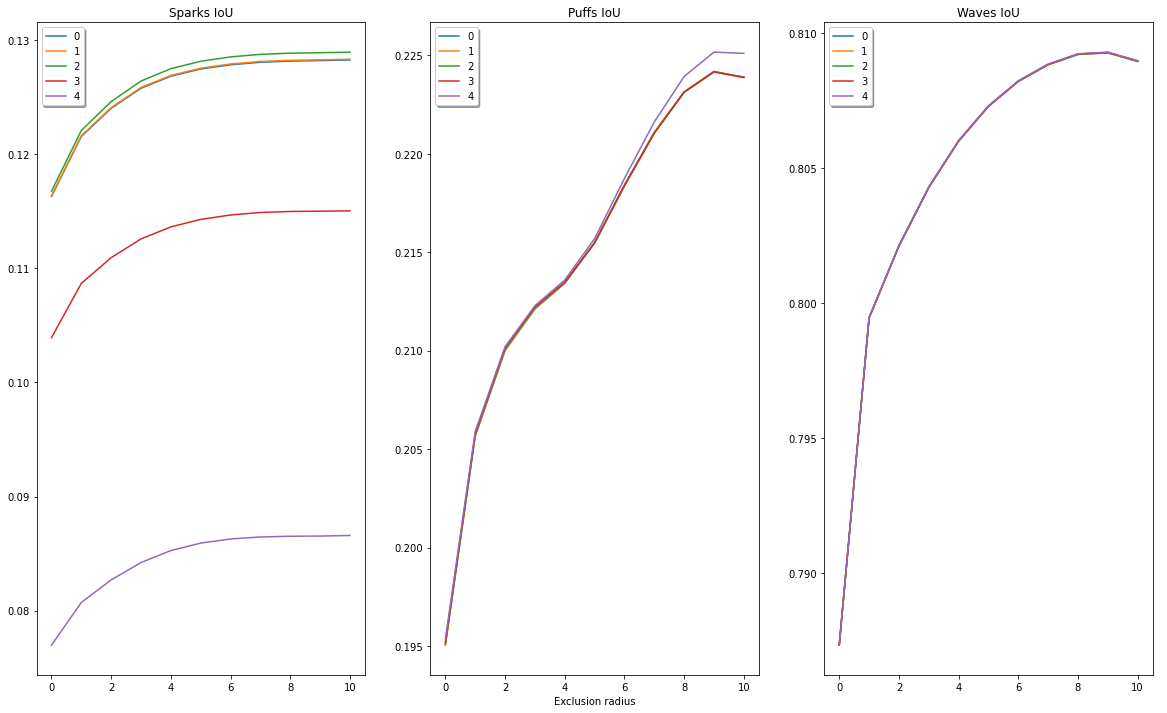

In [31]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for r in min_radius:
    axs[0].plot(exclusion_radius_list, ious_sparks_avg_radius[r], label=r)
           
axs[0].set_title('Sparks IoU')
#axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for r in min_radius:
    axs[1].plot(exclusion_radius_list, ious_puffs_avg_radius[r], label=r)

axs[1].set_title('Puffs IoU')
#axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

for r in min_radius:
    axs[2].plot(exclusion_radius_list, ious_waves_avg_radius[r], label=r)

axs[2].set_title('Waves IoU')
#axs[2].set_ylim([0,1])
axs[2].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

In [32]:
fig.savefig("average_IoU_different_min_event_size_excl_radius.png")

## Compute joined IoU metric for puffs and waves (-> not worth it)

In [10]:
# parameters
ignore_frames = 6

# for focal_loss_gamma_5_ubelix

# puffs and waves params
t_detection = 0.65
min_radius_puffs = 6
min_radius_waves = 8

exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# each dictionary contains, for every training name, a list of IoU scores for all videos for all exclusion radius
ious_puffs_waves_all_trainings = {}

for training_name in training_names:
    print(training_name)
    # get predictions
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
        
    ious_joined_all_video = {}
    
    for video_id in ys_all_trainings.keys():
        ys_sample = ys_all_trainings[video_id]
        puffs_sample = puffs_training[video_id]
        waves_sample = waves_training[video_id]
        
        # get binary predictions and remove ignored frames
        puffs_binary = process_puff_prediction(puffs_sample, 
                                               t_detection, 
                                               min_radius_puffs, 
                                               ignore_frames)
        waves_binary = process_wave_prediction(waves_sample, 
                                               t_detection, 
                                               min_radius_waves, 
                                               ignore_frames)
        joined_binary = np.logical_or(puffs_binary, waves_binary)
        
        # get binary ys and remove ignored frames
        ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
        ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)
        ys_joined_sample = np.logical_or(ys_puffs_sample, ys_waves_sample)
        
        # get ignore mask (events labelled with 4)
        ignore_mask = empty_marginal_frames(np.where(ys_sample==4,1,0), ignore_frames)
        
        # compute IoU for some exclusion radius values
        ious_joined = {}
        for radius in exclusion_radius_list:
            ious_joined[radius] = jaccard_score_exclusion_zone(ys_joined_sample, joined_binary, radius, ignore_mask)
            
        ious_joined_all_video[video_id] = ious_joined

    ious_puffs_waves_all_trainings[training_name] = ious_joined_all_video

focal_loss_gamma_5_ubelix


In [11]:
pprint.pprint(ious_puffs_waves_all_trainings)

{'focal_loss_gamma_5_ubelix': {'05': {0: 0.14759088314881752,
                                      1: 0.139164530721454,
                                      2: 0.10952007091300493,
                                      3: 0.07999067768081415,
                                      4: 0.05123214434884304,
                                      5: 0.027663039375343767,
                                      6: 0.011261883705505196,
                                      7: 0.0029556478954048367,
                                      8: 0.0003009199552918924,
                                      9: 0.0,
                                      10: 0.0},
                               '10': {0: 0.5663674907955643,
                                      1: 0.6396018813866267,
                                      2: 0.6982539775311736,
                                      3: 0.7583326657752198,
                                      4: 0.8181698381740551,
                                      5

### Compute average along videos of IoU for each exclusion radius for each training name

In [12]:
ious_puffs_waves_avg = {} # num training x num exclusion radius

for training_name in training_names:
    num_videos = len(ious_puffs_waves_all_trainings[training_name])
    
    ious_puffs_waves_all_video = ious_puffs_waves_all_trainings[training_name] # num videos x num exclusion radius
    
    ious_puffs_waves_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_puffs_waves_all_video.values()]),0)/num_videos

### Plot average IoU for all trainings and all classes wrt to exclusion radius

In [13]:
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Puffs and Waves']
rows = pd.MultiIndex.from_product([classes, training_names], names=['Class', 'Training name'])

data = [*ious_puffs_waves_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [14]:
display(df)

,Exclusion radius,0,1,2,3,4,5,6,7,8,9,10
Class,Training name,,,,,,,,,,,
Puffs and Waves,focal_loss_gamma_5_ubelix,0.323409,0.348682,0.35969,0.367769,0.372817,0.375519,0.376212,0.375138,0.372672,0.368693,0.36443


In [17]:
df.to_csv("average_IoU_all_trainings_excl_radius_puffs_waves.csv")

Text(0.5, 0, 'Exclusion radius')

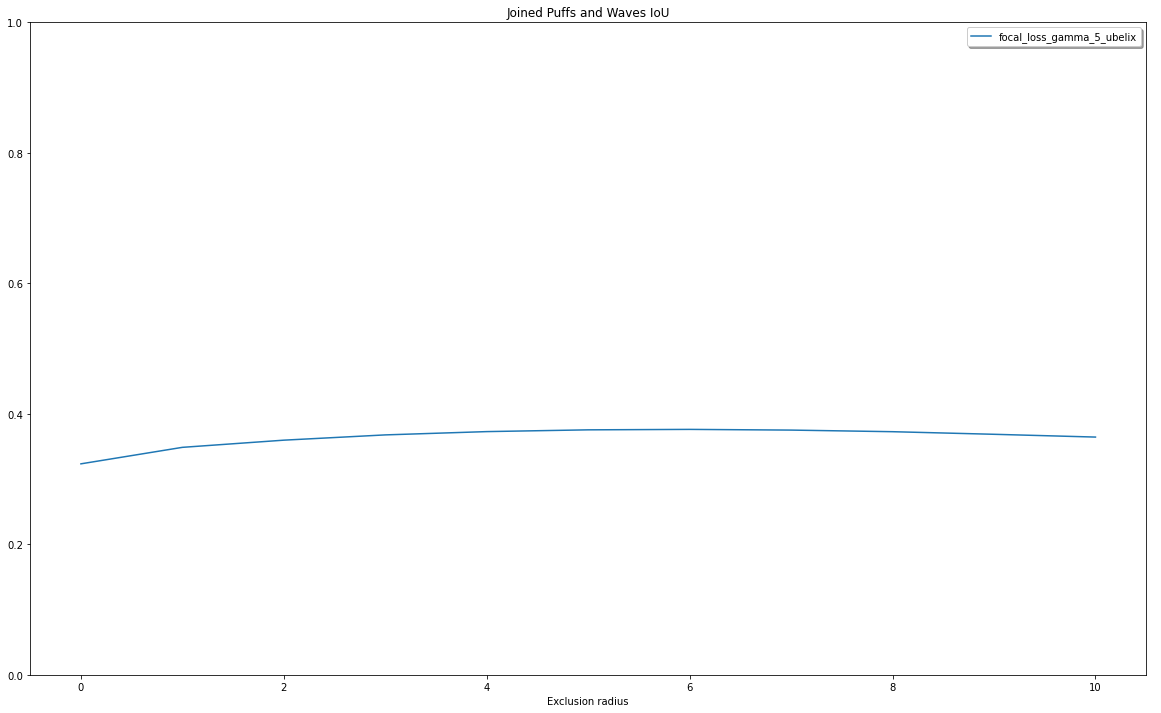

In [23]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs.plot(exclusion_radius_list, ious_puffs_waves_avg[training_name], label=training_name)
           
axs.set_title('Joined Puffs and Waves IoU')
axs.set_ylim([0,1])
axs.legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

In [24]:
fig.savefig("average_IoU_all_trainings_excl_radius_puffs_waves.png")

## Compute puffs IoU using convex hull

Idea: calcolo la convex hull di tutti i predicted puffs e poi calcolo l'IoU per vedere se migliora (in teoria ignora gli sparks on top of puffs).

In [24]:
# training parameters
training_name = "focal_loss_gamma_5_ubelix"
ignore_frames = 6

# detection parameters
t_detection_puffs = [0.5,0.55,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
min_radius_puffs = [0,1,2,3,4,5,6]

In [31]:
puffs_ious = defaultdict(lambda: defaultdict(dict))
puffs_ious_all_movies = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for t in t_detection_puffs:
    for r in min_radius_puffs:
        for movie_name in ys_all_trainings.keys():
            # get puff binary annotations
            puffs_ys = ys[training_name][movie_name]
            puffs_ys = np.where(puffs_ys == 3, 1, 0)
            puffs_ys = empty_marginal_frames(puffs_ys, ignore_frames)
            
            # get ignore mask
            raw_ys = ys_all_trainings[movie_name]
            ignore_mask =  np.where(raw_ys==4,1,0)
            
            # get binary puff prediction
            puffs_pred = puffs[training_name][movie_name]

            # remove holes (convex hull) & small events from puffs
            puffs_pred = process_puff_prediction(pred=puffs_pred,
                                                 t_detection=t,
                                                 min_radius=r,
                                                 ignore_frames=ignore_frames,
                                                 convex_hull=True
                                                )

            # compute IoU
            puffs_ious_all_movies[t][r][movie_name] = jaccard_score_exclusion_zone(ys=puffs_ys,
                                                                       preds=puffs_pred,
                                                                       exclusion_radius=0,
                                                                       ignore_mask=ignore_mask)
        
        # compute average over movies
        puffs_ious[t][r] = sum(puffs_ious_all_movies[t][r].values()) / len(puffs_ious_all_movies[t][r])

Same but without removing holes

In [32]:
puffs_ious_holes = defaultdict(lambda: defaultdict(dict))
puffs_ious_all_movies_holes = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for t in t_detection_puffs:
    for r in min_radius_puffs:
        for movie_name in ys_all_trainings.keys():
            # get puff binary annotations
            puffs_ys = ys[training_name][movie_name]
            puffs_ys = np.where(puffs_ys == 3, 1, 0)
            puffs_ys = empty_marginal_frames(puffs_ys, ignore_frames)
            
            # get ignore mask
            raw_ys = ys_all_trainings[movie_name]
            ignore_mask =  np.where(raw_ys==4,1,0)
            
            # get binary puff prediction
            puffs_pred = puffs[training_name][movie_name]

            # remove holes (convex hull) & small events from puffs
            puffs_pred = process_puff_prediction(pred=puffs_pred,
                                                 t_detection=t,
                                                 min_radius=r,
                                                 ignore_frames=ignore_frames,
                                                 convex_hull=False # <-- difference
                                                )

            # compute IoU
            puffs_ious_all_movies_holes[t][r][movie_name] = jaccard_score_exclusion_zone(ys=puffs_ys,
                                                                       preds=puffs_pred,
                                                                       exclusion_radius=0,
                                                                       ignore_mask=ignore_mask)
        
        # compute average over movies
        puffs_ious_holes[t][r] = sum(puffs_ious_all_movies_holes[t][r].values()) / len(puffs_ious_all_movies_holes[t][r])

### Visualize results using confusion matrices

In [36]:
import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt

In [34]:
df = pd.DataFrame.from_dict(puffs_ious)
df_holes = pd.DataFrame.from_dict(puffs_ious_holes)

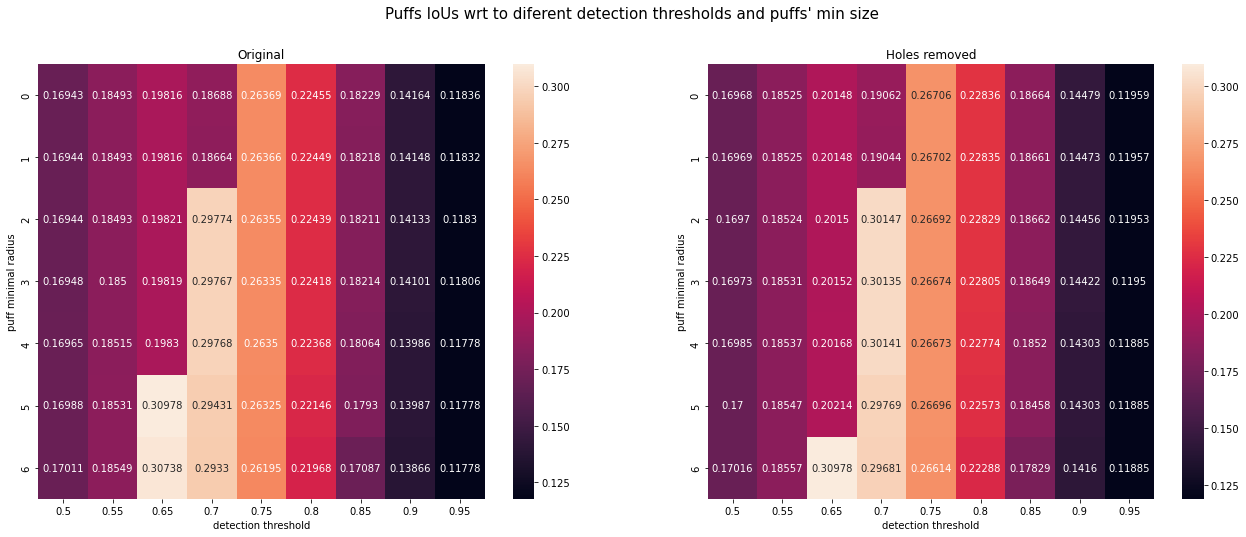

In [53]:
plt.figure(figsize=(22,8))
plt.suptitle(f"Puffs IoUs wrt to diferent detection thresholds and puffs' min size", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Original")
sns.heatmap(df_holes, annot=True, fmt='.5g')
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Holes removed")
sns.heatmap(df, annot=True, fmt='.5g')
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
plt.show()

## Separate events in puffs and waves predictions

Pipeline:

- get puffs and waves predictions
    - extract events using `separate_events`
- get puffs and waves annotations **with separate events** (from new data folder)
    - transform movie from 3 colors to 1 color
    - extract puffs and sparks comparing with {0,1,2,3,4}-annotations
- get ignore mask
- for each event (in puffs/waves/joined)
    - find event with max overlap in annotations
    - if overlap > t => true positive
    - otherwise => false positive
    - store which preds are coupled with which annotations
    - if there is an annotation with no paired event => false negative

In [25]:
from dataset_tools import load_movies_ids

In [165]:
# training params
training_name = "focal_loss_gamma_5_ubelix"
ignore_frames = 6

# puffs and waves params
t_detection = 0.7
min_radius_puffs = 6
min_radius_waves = 8

In [173]:
data_folder = os.path.join(metrics_folder, training_name, "separated_events")
os.makedirs(data_folder, exist_ok=True)

In [32]:
# load all annotations with separated events (!they aren't classified!)
separated_annnotations_path = os.path.join("..","data","raw_data_and_processing","original_separated_events_masks")
movie_names = ys_all_trainings.keys()

separated_annotations = load_movies_ids(data_folder=separated_annnotations_path, ids=movie_names)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [166]:
movie_name = '05'

In [167]:
# get puff and wave annotation masks
ys_sample = ys[training_name][movie_name]
puff_ys = np.where(ys_sample == 3, 1., 0.)
wave_ys = np.where(ys_sample == 2, 1., 0.)

# get puff and wave annotations with separate events
ys_rgb = np.array(separated_annotations[movie_name], dtype=np.int32)

# transform RGB to integer by 255*255*r + 255*g + b and set white to 0
ys_events = 255*255*ys_rgb[...,0] + 255*ys_rgb[...,1] + ys_rgb[...,2]
white_int = 255*255*255+255*255+255
ys_events[ys_events == white_int] = 0

# get separated annotated puff and wave events
puff_ys_events = np.where(puff_ys, ys_separated_events, 0)
puff_ys_events = empty_marginal_frames(puff_ys_events, ignore_frames)

wave_ys_events = np.where(wave_ys, ys_separated_events, 0)
wave_ys_events = empty_marginal_frames(wave_ys_events, ignore_frames)

In [168]:
# get puff and wave predictions
puff_preds = puffs[training_name][movie_name]
wave_preds = waves[training_name][movie_name]

# get binary predicted puff and wave events
puff_pred_binary = process_puff_prediction(pred=puff_preds,
                                           t_detection=t_detection,
                                           min_radius=min_radius_puffs,
                                           ignore_frames=ignore_frames,
                                           convex_hull=True
                                          )
wave_pred_binary = process_wave_prediction(pred=wave_preds,
                                           t_detection=t_detection,
                                           min_radius=min_radius_waves,
                                           ignore_frames=ignore_frames
                                          )

In [169]:
import cc3d

In [170]:
# identify events in puff and wave preds
connectivity = 26
puff_labels, puff_n_events = cc3d.connected_components(puff_pred_binary, 
                                                       connectivity=connectivity,
                                                       return_N=True
                                                      )

In [172]:
imageiopuff_n_events

15

# Sparks metrics (TODO)

In [9]:
from metrics_tools import compute_prec_rec, reduce_metrics_thresholds

In [10]:
# physiological params
PIXEL_SIZE = 0.2 # 1 pixel = 0.2 um x 0.2 um
MIN_DIST_XY = round(1.8 / PIXEL_SIZE) # min distance in space between sparks
TIME_FRAME = 6.8 # 1 frame = 6.8 ms
MIN_DIST_T = round(20 / TIME_FRAME) # min distance in time between sparks

# parameters
ignore_frames = 6

## Plain precision and recall

In [10]:
t_detection_sparks = 0.7
min_radius_sparks = 2 # min radius of a detected spark

In [17]:
# parameters
ignore_frames = 6

t_detection_sparks = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

min_radius_sparks = 2

# each dictionary contains, for every training name, a list of prec rec scores for all videos for all thresholds
prec_rec_sparks_all_trainings = {} # num trainings x num video x num thresholds

for training_name in training_names:
    print(training_name)
    # get predictions
    sparks_training = sparks[training_name]
    
    # get annotations
    ys_training = ys[training_name]
    
    prec_rec_sparks_all_video = {}
    
    for video_id in ys_all_trainings.keys():
        print(video_id)
        sparks_sample = sparks_training[video_id]
        ys_sample = ys_training[video_id]
        ys_raw = ys_all_trainings[video_id]
        
        # get binary ys 
        ys_sparks_sample = np.where(ys_sample==1,1.0,0.0)
        
        # get ignore mask
        ignore_mask =  np.where(ys_raw==4,1,0)
            
        # compute precision and recall for some thresholds and remove ignored frames
        prec_rec_all_t = compute_prec_rec(annotations=ys_sparks_sample, 
                                          preds=sparks_sample, 
                                          thresholds=t_detection_sparks, 
                                          ignore_frames=ignore_frames,
                                          min_radius=min_radius_sparks, 
                                          min_dist_xy=MIN_DIST_XY,
                                          min_dist_t=MIN_DIST_T,
                                          ignore_mask=ignore_mask
                                         ) # dict indexed by threshold value
        
        pprint.pprint(dict(prec_rec_all_t))
        prec_rec_sparks_all_video[video_id] = prec_rec_all_t
        
    prec_rec_sparks_all_trainings[training_name] = prec_rec_sparks_all_video

focal_loss_gamma_5_ubelix
05
{0.5: Metrics(precision=0.1326530612244898, recall=0.37142857142857144, tp=26, tp_fp=196, tp_fn=70),
 0.55: Metrics(precision=0.13068181818181818, recall=0.32857142857142857, tp=23, tp_fp=176, tp_fn=70),
 0.6: Metrics(precision=0.13664596273291926, recall=0.3142857142857143, tp=22, tp_fp=161, tp_fn=70),
 0.65: Metrics(precision=0.14583333333333334, recall=0.3, tp=21, tp_fp=144, tp_fn=70),
 0.7: Metrics(precision=0.15748031496062992, recall=0.2857142857142857, tp=20, tp_fp=127, tp_fn=70),
 0.75: Metrics(precision=0.21052631578947367, recall=0.2857142857142857, tp=20, tp_fp=95, tp_fn=70),
 0.8: Metrics(precision=0.35555555555555557, recall=0.22857142857142856, tp=16, tp_fp=45, tp_fn=70),
 0.85: Metrics(precision=0.5555555555555556, recall=0.07142857142857142, tp=5, tp_fp=9, tp_fn=70),
 0.9: Metrics(precision=1.0, recall=0.014285714285714285, tp=1, tp_fp=1, tp_fn=70),
 0.95: Metrics(precision=1.0, recall=0.0, tp=0, tp_fp=0, tp_fn=70)}
10
{0.5: Metrics(precisio

### Average over all videos

In [18]:
prec_rec_sparks_avg = {} # num training x num thresholds
prec_avg = {}
rec_avg = {}

for training_name in training_names:
    prec_rec_all_videos = prec_rec_sparks_all_trainings[training_name]
    prec_rec_sparks_avg[training_name] = reduce_metrics_thresholds(prec_rec_all_videos)
    prec_avg[training_name] = prec_rec_sparks_avg[training_name][1]
    rec_avg[training_name] = prec_rec_sparks_avg[training_name][2]

### Dataframe and plots of results

In [19]:
cols = pd.Index(t_detection_sparks, name='Detection threshold')
metrics = ['Precision', 'Recall']
rows = pd.MultiIndex.from_product([metrics, training_names], names=['Class', 'Training name'])

data = [*prec_avg.values(),
        *rec_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [20]:
display(df)

,Detection threshold,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
Class,Training name,,,,,,,,,,
Precision,focal_loss_gamma_5_ubelix,0.084759,0.104753,0.132616,0.167905,0.207101,0.278107,0.365517,0.500000,1.000000,1.0
Recall,focal_loss_gamma_5_ubelix,0.417625,0.413793,0.425287,0.432950,0.402299,0.360153,0.203065,0.022989,0.003831,0.0


In [21]:
df.to_csv("sparks_precision_recall.csv")

Text(0.5, 0, 'Detection threshold')

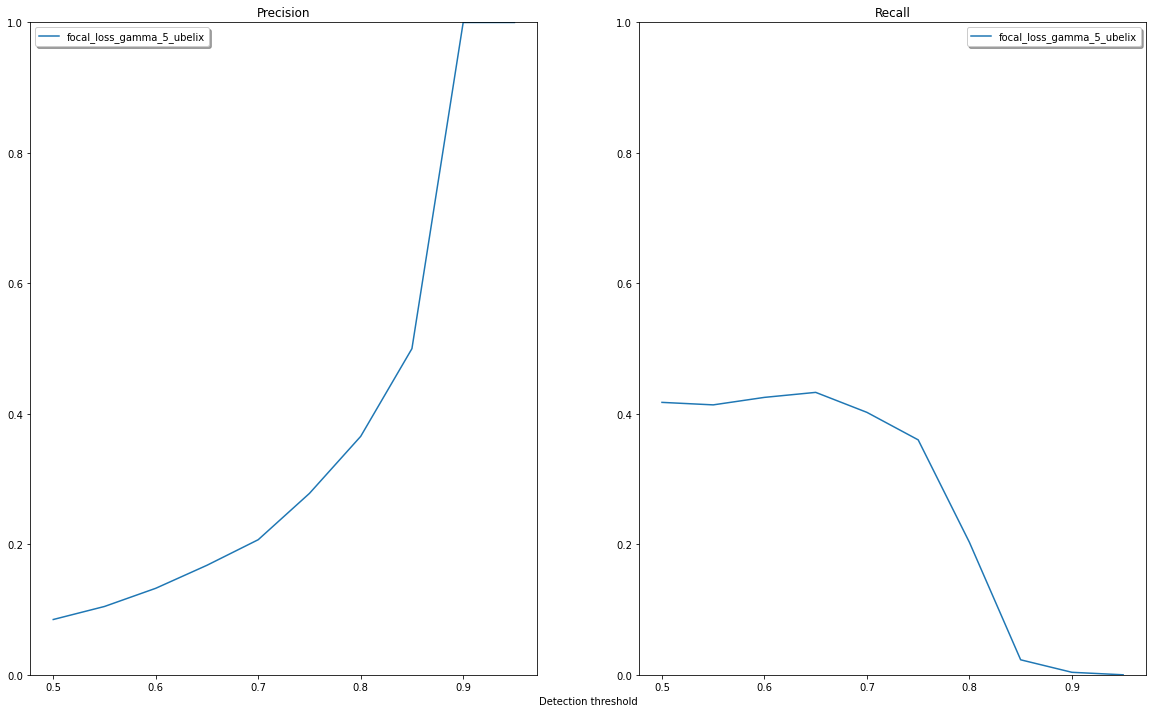

In [22]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs[0].plot(t_detection_sparks, prec_avg[training_name].values(), label=training_name)
           
axs[0].set_title('Precision')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[1].plot(t_detection_sparks, rec_avg[training_name].values(), label=training_name)

axs[1].set_title('Recall')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Detection threshold")

In [23]:
fig.savefig("sparks_precision_recall.png")

## Set lower threshold for sparks inside puffs

Idee : 

- rendere i puffs convessi e controllare se lo spark interseca il puff
- sommare la probabilità di puff e sparks se e.g. puff > 0 e sparks > 0.7 <-- provo prima con questa possibilità perché non sempre gli sparks sono all'interno dei puffs

### Sum puff probabilities to sparks (just for one training)

In [25]:
training_name = "focal_loss_gamma_5_ubelix"

ignore_frames = 6

t_puffs_lower = 0.3
t_puffs_upper = [0.0,0.5,0.55,0.6,0.65] # = t detection puffs (0 for standard detection) (t included)

t_detection_sparks = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] # for sum of puffs and sparks (t not included)

min_radius_sparks = [0,1,2] # da vedere come usarlo

In [39]:
from metrics_tools import compute_prec_rec, reduce_metrics_thresholds

In [40]:
prec_rec_auc = defaultdict(lambda: defaultdict(dict))
prec_rec_auc_all_movies = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for min_r in min_radius_sparks:
    print(f"sparks' min radius: {min_r}")
    for t_p in t_puffs_upper:
        print(f"puffs' upper threshold: {t_p}")
        for movie_name in ys_all_trainings.keys():
            print(f"movie's name: {movie_name}")
            # open spark preds :
            sparks_pred = sparks[training_name][movie_name]
            # open puff preds :
            puffs_pred = puffs[training_name][movie_name]
            
            # process spark & puff preds together :
            # compute region where 0.3 <= puffs <= 0.65
            binary_puffs_sparks = np.logical_and(puffs_pred <= t_p, puffs_pred >= t_puffs_lower)
            # sum value of sparks and puffs in this region
            sparks_pred_total = sparks_pred + binary_puffs_sparks * puffs_pred
            
            # get binary annotation mask
            ys_sparks = ys[training_name][movie_name]
            binary_ys_sparks = np.where(ys_sparks==1,1.0,0.0)
            
            # get ignore mask
            ys_raw = ys_all_trainings[movie_name]
            ignore_mask =  np.where(ys_raw==4,1,0)
            
            # compute prec & rec for all t_detection_sparks
            prec_rec_all_t, auc = compute_prec_rec(annotations=binary_ys_sparks,
                                                   preds=sparks_pred_total,
                                                   thresholds=t_detection_sparks,
                                                   ignore_frames=ignore_frames,
                                                   min_radius=min_r,
                                                   min_dist_xy=MIN_DIST_XY,
                                                   min_dist_t=MIN_DIST_T,
                                                   ignore_mask=ignore_mask
                                                  ) # dict indexed by threshold value
            #print(f"precision and recall for all t_detection_sparks: {prec_rec_all_t}")
            
            # get dict of Metrics for each min_r, t_p, movie_name
            prec_rec_auc_all_movies[min_r][t_p][movie_name] = (prec_rec_all_t, auc)            
            
        # get only prec & rec metrics for all movies
        metrics_dict = {movie_name: metrics[0] for (movie_name, metrics) in prec_rec_auc_all_movies[min_r][t_p].items()}
        #pprint.pprint(metrics_dict)
        
        # reduce prec & rec over all movies and compute AUC
        reduced_prec_rec, _, _, reduced_auc = reduce_metrics_thresholds(metrics_dict)
        #pprint.pprint(reduced_prec_rec)
        #print(reduced_auc)
        prec_rec_auc[min_r][t_p] = (reduced_prec_rec, reduced_auc)

# obtain dicts s.t. 
#prec_rec_auc[min_r][t_p] = (reduced metrics, reduced AUC)
#prec_rec_auc_all_movies[min_r][t_p][movie_name] = (movie_name's metrics, movie_name's AUC)

sparks' min radius: 0
puffs' upper threshold: 0.0
movie's name: 05
movie's name: 10
movie's name: 15
movie's name: 20
movie's name: 25
movie's name: 32
movie's name: 34
movie's name: 40
movie's name: 45
puffs' upper threshold: 0.5
movie's name: 05


ValueError: x is neither increasing nor decreasing : [0.71428571 0.72857143 0.62857143 0.51428571 0.41428571 0.34285714
 0.2       ].

In [ ]:
pprint.pprint(prec_rec_auc_all_movies)

#### Average over all movies 

In [ ]:
'''ious_sparks_avg = {} # num training x num exclusion radius
ious_puffs_avg = {}
ious_waves_avg = {}

for training_name in training_names:
    num_videos = len(ious_sparks_all_trainings[training_name])
    
    ious_sparks_all_video = ious_sparks_all_trainings[training_name] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_trainings[training_name] 
    ious_waves_all_video = ious_waves_all_trainings[training_name]
    
    ious_sparks_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_sparks_all_video.values()]),0)/num_videos
    ious_puffs_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_puffs_all_video.values()]),0)/num_videos
    ious_waves_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_waves_all_video.values()]),0)/num_videos''';

In [14]:
from metrics_tools import reduce_metrics_thresholds

In [15]:
# reverse dictionaires
res = defaultdict(lambda: defaultdict(dict)) # t_upper x min_radius x num movies x t
for movie_name, prec_rec in all_movies_prec_rec.items():
    for t_upper, t_upper_prec_rec in prec_rec.items():
        for min_radius, min_r_prec_rec in t_upper_prec_rec.items():
            res[t_upper][min_radius][movie_name] = min_r_prec_rec

In [74]:
# compute average over movies
avg_prec_rec = defaultdict(lambda: defaultdict(dict))
for t_upper, t_upper_prec_rec in res.items():
    for min_radius, min_r_prec_rec in t_upper_prec_rec.items():
        # get Metrics object and transform it to dict
        metrics = reduce_metrics_thresholds(min_r_prec_rec)[0]
        metrics = metrics[list(metrics)[0]]._asdict()
        #print(metrics)
        for metric in Metrics._fields:
            #print(metric)
            #print(metrics[metric])
            avg_prec_rec[metric][t_upper][min_radius] = metrics[metric]

### Results visualization

In [134]:
for k,v in avg_prec_rec.items():
    print(k,v)

precision defaultdict(<class 'dict'>, {0.0: {0: 0.21079691516709512, 1: 0.22869318181818182, 2: 0.2744360902255639}, 0.5: {0: 0.18319838056680163, 1: 0.20135746606334842, 2: 0.24287856071964017}, 0.55: {0: 0.17829457364341086, 1: 0.19271948608137046, 2: 0.23470839260312945}, 0.6: {0: 0.17481203007518797, 1: 0.19047619047619047, 2: 0.2269021739130435}, 0.65: {0: 0.17088607594936708, 1: 0.18514851485148515, 2: 0.2198952879581152}})
recall defaultdict(<class 'dict'>, {0.0: {0: 0.6283524904214559, 1: 0.6168582375478927, 2: 0.5593869731800766}, 0.5: {0: 0.6934865900383141, 1: 0.6819923371647509, 2: 0.6206896551724138}, 0.55: {0: 0.7049808429118773, 1: 0.6896551724137931, 2: 0.632183908045977}, 0.6: {0: 0.7126436781609196, 1: 0.7049808429118773, 2: 0.6398467432950191}, 0.65: {0: 0.7241379310344828, 1: 0.7164750957854407, 2: 0.6436781609195402}})
tp defaultdict(<class 'dict'>, {0.0: {0: 164, 1: 161, 2: 146}, 0.5: {0: 181, 1: 178, 2: 162}, 0.55: {0: 184, 1: 180, 2: 165}, 0.6: {0: 186, 1: 184, 

In [136]:
# create a dict of dataframes over metric type
df_dict = {k: pd.DataFrame(v) for k, v in avg_prec_rec.items()}

In [120]:
df_simple = pd.concat({k: pd.DataFrame(v) for k, v in avg_prec_rec.items()})

In [119]:
cols = pd.Index(t_puffs_upper, name='Puffs upper bounds')
classes = Metrics._fields
rows = pd.MultiIndex.from_product([classes, min_radius_sparks], names=['Metrics', 'Sparks min size'])

#data = [*ious_sparks_avg.values(),
#       *ious_puffs_avg.values(),
#       *ious_waves_avg.values()
#      ]

#pprint.pprint(list(dict(avg_prec_rec).values()))

#data = [[list(radius_dict.values())]  for metric_dict in avg_prec_rec.values() 
#        for radius_dict in list(dict(metric_dict).values())
#       ]

data = [metric_res for metric_dict in avg_prec_rec.values() for metric_res in metric_dict]

print("num t_upper", len(t_puffs_upper))
print("num min size", len(min_radius_sparks))
print("num metrics", len(Metrics._fields))
pprint.pprint(data)

df = pd.DataFrame(data, rows, cols)

num t_upper 5
num min size 3
num metrics 5
[0.0,
 0.5,
 0.55,
 0.6,
 0.65,
 0.0,
 0.5,
 0.55,
 0.6,
 0.65,
 0.0,
 0.5,
 0.55,
 0.6,
 0.65,
 0.0,
 0.5,
 0.55,
 0.6,
 0.65,
 0.0,
 0.5,
 0.55,
 0.6,
 0.65]


ValueError: Shape of passed values is (25, 1), indices imply (15, 5)

In [116]:
display(df)

,Puffs upper bounds,0.00,0.50,0.55,0.60,0.65
Metrics,Sparks min size,,,,,
precision,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN
recall,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN
tp,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN
tp_fp,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN
tp_fn,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN


In [137]:
from pandasgui import show
show(*list(df_dict.values()))

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
PandasGUI WARNING — pandasgui.utility — In untitled_1, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
PandasGUI WARNING — pandasgui.utility — In untitled_2, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
PandasGUI WARNING — pandasgui.utility — In untitled_3, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
PandasGUI WARNING — pandasgui.utility — In untitled_4, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
PandasGUI WARNING — pandasgui.utility — In untitled_5, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
